In [36]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [37]:
try:
    data = pd.read_csv("ctr.csv")
    print("Initial Data:")
    print(data.head())
except FileNotFoundError:
    print("Error: The file 'ctr.csv' was not found. Please ensure the file exists in the specified directory.")


Initial Data:
         Date  Clicks  Impressions
0  2022-10-19    2851        58598
1  2022-10-20    2707        57628
2  2022-10-21    2246        50135
3  2022-10-22    1686        40608
4  2022-10-23    1808        41999


In [38]:
print("\nOriginal Column Names:", data.columns.tolist())
data.columns = data.columns.str.strip()
print("After Stripping Spaces:", data.columns.tolist())

if 'Date' not in data.columns:
    raise KeyError("The 'Date' column is missing from the DataFrame. Please check the CSV file.")
else:
    print("The 'Date' column is present.")
try:
    data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
    print("Date conversion successful using format='%Y-%m-%d'.")
except ValueError as e:
    print(f"ValueError during date conversion: {e}")
    print("Attempting to parse dates without specifying the format.")
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

num_nat = data['Date'].isna().sum()
if num_nat > 0:
    print(f"\nWarning: {num_nat} dates could not be parsed and are set to NaT. Please check the data.")
    print("Rows with unparsed dates:")
    print(data[data['Date'].isna()])
else:
    print("All dates parsed successfully.")

data.set_index('Date', inplace=True)
print("\n'Date' has been set as the index.")

print("\nData after processing:")
print(data.head())
print("\nData types:")
print(data.dtypes)
print("\nIndex name:", data.index.name)



Original Column Names: ['Date', 'Clicks', 'Impressions']
After Stripping Spaces: ['Date', 'Clicks', 'Impressions']
The 'Date' column is present.
Date conversion successful using format='%Y-%m-%d'.
All dates parsed successfully.

'Date' has been set as the index.

Data after processing:
            Clicks  Impressions
Date                           
2022-10-19    2851        58598
2022-10-20    2707        57628
2022-10-21    2246        50135
2022-10-22    1686        40608
2022-10-23    1808        41999

Data types:
Clicks         int64
Impressions    int64
dtype: object

Index name: Date


In [39]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['Clicks'], 
    mode='lines', 
    name='Clicks',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter(
    x=data.index, 
    y=data['Impressions'], 
    mode='lines', 
    name='Impressions',
    line=dict(color='green')
))

fig.update_layout(
    title='Clicks and Impressions Over Time',
    xaxis_title='Date',
    yaxis_title='Count',
    legend=dict(x=0.1, y=0.9),
    template='plotly_dark'
)
fig.show()


In [40]:
fig = px.scatter(
    data, 
    x='Clicks', 
    y='Impressions', 
    title='Relationship Between Clicks and Impressions',
    labels={'Clicks': 'Clicks', 'Impressions': 'Impressions'},
    trendline='ols',  
    template='plotly_dark'
)

fig.update_layout(
    xaxis_title='Clicks',
    yaxis_title='Impressions'
)
fig.show()


In [41]:
data['CTR'] = (data['Clicks'] / data['Impressions']) * 100

fig = px.line(
    data, 
    x=data.index, 
    y='CTR', 
    title='Click-Through Rate (CTR) Over Time',
    labels={'CTR': 'CTR (%)'},
    template='plotly_dark'
)

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='CTR (%)',
    showlegend=False
)
fig.show()


## Exploratory Data Analysis (EDA) Based on Day of the Week

In [42]:
data['DayOfWeek'] = data.index.dayofweek
day_of_week_ctr = data.groupby('DayOfWeek')['CTR'].mean().reset_index()

day_mapping = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
day_of_week_ctr['DayOfWeek'] = day_of_week_ctr['DayOfWeek'].map(day_mapping)

day_of_week_ctr = day_of_week_ctr.sort_values('DayOfWeek')

fig = px.bar(
    day_of_week_ctr, 
    x='DayOfWeek', 
    y='CTR', 
    title='Average CTR by Day of the Week',
    labels={'CTR': 'Average CTR (%)', 'DayOfWeek': 'Day of the Week'},
    template='plotly_dark',
    color='DayOfWeek',
    color_discrete_sequence=px.colors.qualitative.Dark24
)

fig.update_layout(
    xaxis_title='Day of the Week',
    yaxis_title='Average CTR (%)',
    showlegend=False
)
fig.show()


## Comparing Weekdays and Weekends

In [43]:
data['DayCategory'] = data['DayOfWeek'].apply(lambda x: 'Weekend' if x in ['Sat', 'Sun'] else 'Weekday')

ctr_by_day_category = data.groupby('DayCategory')['CTR'].mean().reset_index()

fig = px.bar(
    ctr_by_day_category, 
    x='DayCategory', 
    y='CTR', 
    title='Comparison of CTR on Weekdays vs. Weekends',
    labels={'CTR': 'Average CTR (%)', 'DayCategory': 'Day Category'},
    template='plotly_dark',
    color='DayCategory',
    color_discrete_sequence=['#636EFA', '#EF553B']
)

fig.update_layout(
    xaxis_title='Day Category',
    yaxis_title='Average CTR (%)',
    showlegend=False
)
fig.show()


## Comparing Clicks and Impressions on Weekdays and Weekends

In [44]:
grouped_data = data.groupby('DayCategory')[['Clicks', 'Impressions']].sum().reset_index()

fig = px.bar(
    grouped_data, 
    x='DayCategory', 
    y=['Clicks', 'Impressions'],
    title='Impressions and Clicks on Weekdays vs. Weekends',
    labels={'value': 'Count', 'variable': 'Metric', 'DayCategory': 'Day Category'},
    template='plotly_dark',
    barmode='group',
    color_discrete_sequence=['#636EFA', '#EF553B']
)
fig.update_layout(
    yaxis_title='Count',
    xaxis_title='Day Category',
    legend_title='Metric'
)
fig.show()


## Forecasting CTR Using SARIMA
## Preparing the Time Series for Forecasting

In [45]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
data.reset_index(inplace=True)

time_series = data.set_index('Date')['CTR']


## Identifying p, d, q Parameters Using ACF and PACF

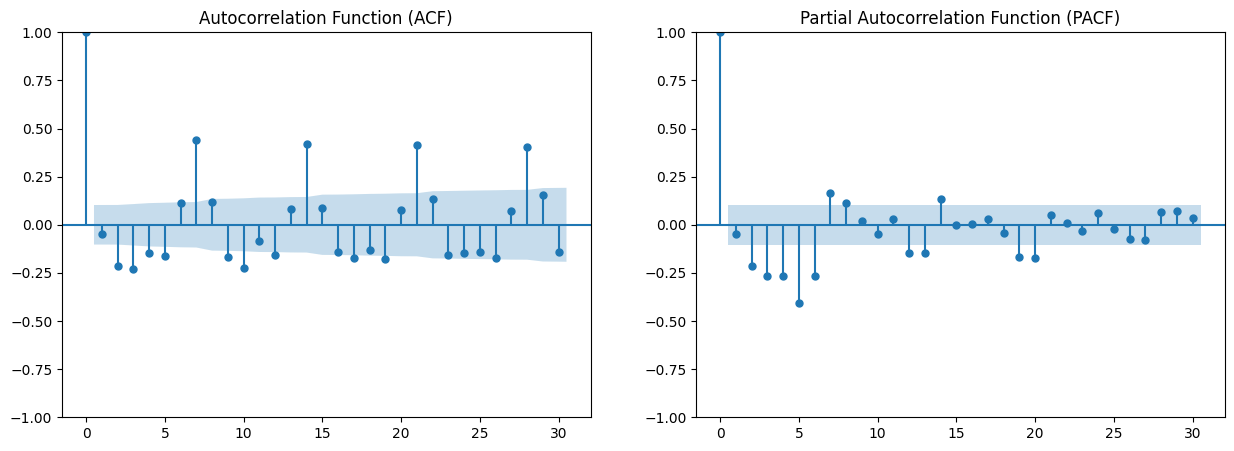

In [46]:
differenced_series = time_series.diff().dropna()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(differenced_series, ax=axes[0], lags=30)
plot_pacf(differenced_series, ax=axes[1], lags=30, method='ywm')
axes[0].set_title('Autocorrelation Function (ACF)')
axes[1].set_title('Partial Autocorrelation Function (PACF)')
plt.show()


In [47]:
p, d, q, s = 1, 1, 1, 7  

model = SARIMAX(time_series, order=(p, d, q), seasonal_order=(p, d, q, s))

results = model.fit()
print(results.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32352D-02    |proj g|=  1.22728D+00

At iterate    5    f= -3.32308D-02    |proj g|=  1.75012D-01

At iterate   10    f= -8.16113D-02    |proj g|=  1.90357D-01

At iterate   15    f= -8.66821D-02    |proj g|=  9.31888D-02

At iterate   20    f= -8.75505D-02    |proj g|=  9.26052D-03

At iterate   25    f= -8.75713D-02    |proj g|=  4.37200D-04


 This problem is unconstrained.



At iterate   30    f= -8.75721D-02    |proj g|=  4.22854D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     39      1     0     0   1.103D-05  -8.757D-02
  F =  -8.7572098430979767E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                     
Dep. Variable:                               CTR   No. Observations:                  365
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                  31.964
Date:                           Thu, 26 Dec 2024   AIC                            -53.928
T

## Forecasting Future CTR Values

In [48]:
future_steps = 30  
predictions = results.get_forecast(steps=future_steps)
predicted_mean = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

last_date = time_series.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps, freq='D')

forecast = pd.DataFrame({
    'Predicted_CTR': predicted_mean.values,
    'Lower_CI': confidence_intervals['lower CTR'].values,
    'Upper_CI': confidence_intervals['upper CTR'].values
}, index=forecast_dates)
print(forecast.head())


            Predicted_CTR  Lower_CI  Upper_CI
2023-10-19       3.910703  3.488053  4.333354
2023-10-20       3.689846  3.204142  4.175549
2023-10-21       3.365838  2.849663  3.882013
2023-10-22       3.648490  3.110410  4.186571
2023-10-23       3.870859  3.313855  4.427864


In [49]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=time_series.index, 
    y=time_series, 
    mode='lines', 
    name='Original CTR',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=forecast.index, 
    y=forecast['Predicted_CTR'], 
    mode='lines', 
    name='Forecasted CTR',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=forecast.index.tolist() + forecast.index[::-1].tolist(),
    y=forecast['Upper_CI'].tolist() + forecast['Lower_CI'][::-1].tolist(),
    fill='toself',
    fillcolor='rgba(255, 165, 0, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    showlegend=True,
    name='Confidence Interval'
))

fig.update_layout(
    title='CTR Forecasting',
    xaxis_title='Date',
    yaxis_title='CTR (%)',
    legend=dict(x=0.1, y=0.9),
    template='plotly_dark'
)
fig.show()
